## 1. Setup and Imports

Let's start by importing the necessary packages.

In [1]:
# Core numerical and plotting libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# SpotOptim for optimization
from spotoptim import SpotOptim

# For comparison: scipy's LHS implementation
from scipy.stats import qmc

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("✓ All packages imported successfully!")

✓ All packages imported successfully!


## 2. Why Sampling Plans Matter

### The Problem with Random Sampling

When building a surrogate model, we need to sample the design space efficiently. Consider these two approaches:

1. **Random Sampling**: Points are scattered randomly
2. **Space-Filling Design**: Points are strategically placed to cover the space uniformly

Let's visualize the difference in 2D:

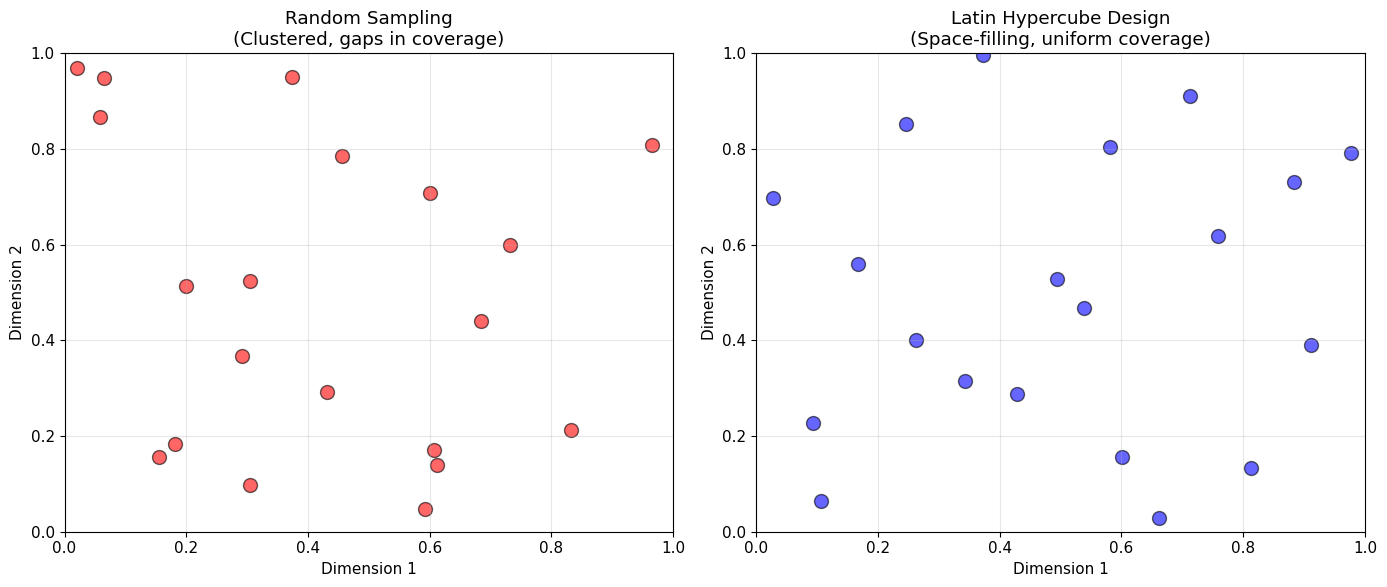

Random sampling: Points may cluster, leaving gaps
LHD: Points distributed to maximize coverage


In [2]:
# Number of sample points
n_samples = 20

# Random sampling
random_samples = np.random.uniform(0, 1, size=(n_samples, 2))

# Latin Hypercube Sampling (using scipy for comparison)
sampler = qmc.LatinHypercube(d=2, seed=42)
lhs_samples = sampler.random(n=n_samples)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Random sampling plot
ax1.scatter(random_samples[:, 0], random_samples[:, 1], s=100, c='red', alpha=0.6, edgecolors='black')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')
ax1.set_title('Random Sampling\n(Clustered, gaps in coverage)')
ax1.grid(True, alpha=0.3)

# LHS plot
ax2.scatter(lhs_samples[:, 0], lhs_samples[:, 1], s=100, c='blue', alpha=0.6, edgecolors='black')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')
ax2.set_title('Latin Hypercube Design\n(Space-filling, uniform coverage)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Random sampling: Points may cluster, leaving gaps")
print(f"LHD: Points distributed to maximize coverage")

### Key Observations:

- **Random sampling** creates clusters and leaves large unexplored regions
- **Latin Hypercube Design** spreads points more uniformly across the space
- Better space coverage → Better surrogate model → Faster convergence

## 3. What is Latin Hypercube Design (LHD)?

### Definition

Latin Hypercube Design is a **stratified sampling** technique that ensures:
- Each dimension is divided into *n* equally-spaced intervals
- Exactly **one sample** is placed in each interval per dimension
- Points are randomly permuted to avoid alignment

### Why "Latin Hypercube"?

The name comes from **Latin Squares** in combinatorics:
- In a Latin Square, each row and column contains each element exactly once
- LHD extends this concept to multiple dimensions (hypercube)

### Mathematical Properties

For *n* samples in *d* dimensions:
1. Divide each dimension into *n* equal intervals: $[0, 1/n), [1/n, 2/n), ..., [(n-1)/n, 1]$
2. For dimension *i*, randomly permute the intervals: $\pi_i$
3. Sample point *j* in dimension *i*: $x_{ji} = \frac{\pi_i(j) + u_{ji}}{n}$ where $u_{ji} \sim U(0,1)$

This guarantees **one-dimensional projection uniformity**: if you project the points onto any axis, they're evenly distributed.

## 4. Latin Hypercube Design in 1D

Let's build intuition by starting with the simplest case: 1 dimension.

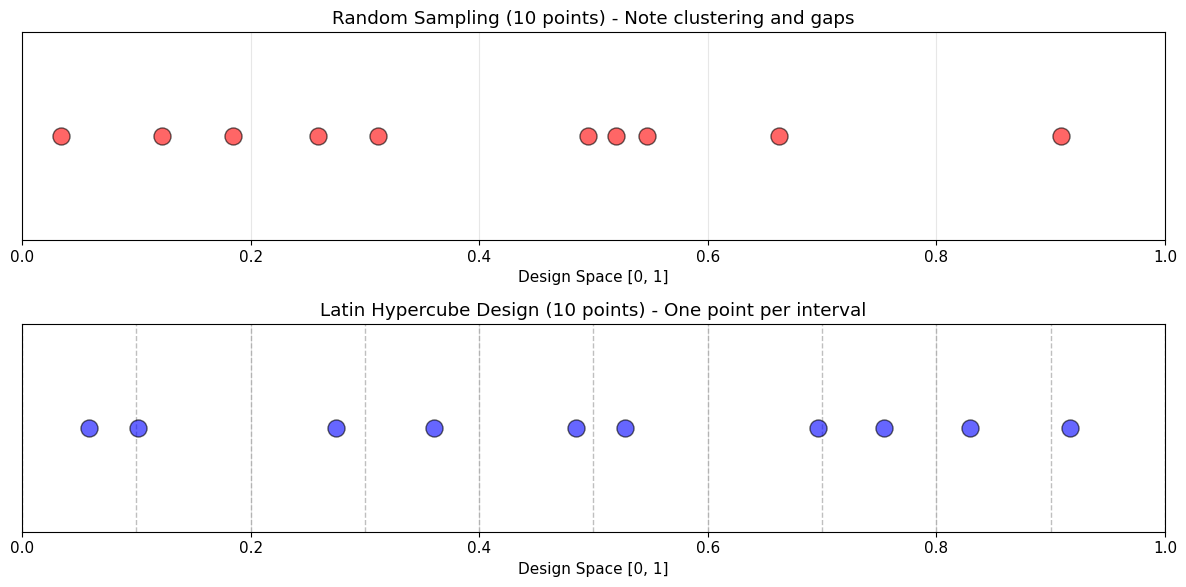


📊 Key Insight:
LHD divides the space into equal intervals and ensures exactly one sample per interval.
This prevents clustering and guarantees uniform coverage.


In [3]:
def visualize_1d_lhd(n_samples=10):
    """Visualize how LHD works in 1 dimension."""
    
    # Create intervals
    intervals = np.linspace(0, 1, n_samples + 1)
    
    # Random sampling for comparison
    random_points = np.random.uniform(0, 1, n_samples)
    
    # LHS: one point per interval
    lhs_points = []
    permutation = np.random.permutation(n_samples)
    for i in permutation:
        # Random point within interval i
        point = intervals[i] + np.random.uniform(0, 1/n_samples)
        lhs_points.append(point)
    lhs_points = np.array(lhs_points)
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    
    # Random sampling
    ax1.scatter(random_points, np.zeros_like(random_points), s=150, c='red', alpha=0.6, edgecolors='black', zorder=3)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(-0.5, 0.5)
    ax1.set_xlabel('Design Space [0, 1]')
    ax1.set_yticks([])
    ax1.set_title(f'Random Sampling ({n_samples} points) - Note clustering and gaps')
    ax1.grid(True, alpha=0.3)
    
    # LHS
    ax2.scatter(lhs_points, np.zeros_like(lhs_points), s=150, c='blue', alpha=0.6, edgecolors='black', zorder=3)
    # Draw intervals
    for i in range(n_samples + 1):
        ax2.axvline(x=intervals[i], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(-0.5, 0.5)
    ax2.set_xlabel('Design Space [0, 1]')
    ax2.set_yticks([])
    ax2.set_title(f'Latin Hypercube Design ({n_samples} points) - One point per interval')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize
visualize_1d_lhd(n_samples=10)

print("\n📊 Key Insight:")
print("LHD divides the space into equal intervals and ensures exactly one sample per interval.")
print("This prevents clustering and guarantees uniform coverage.")

## 5. Latin Hypercube Design in 2D

Now let's see how LHD extends to 2 dimensions with a detailed visualization.

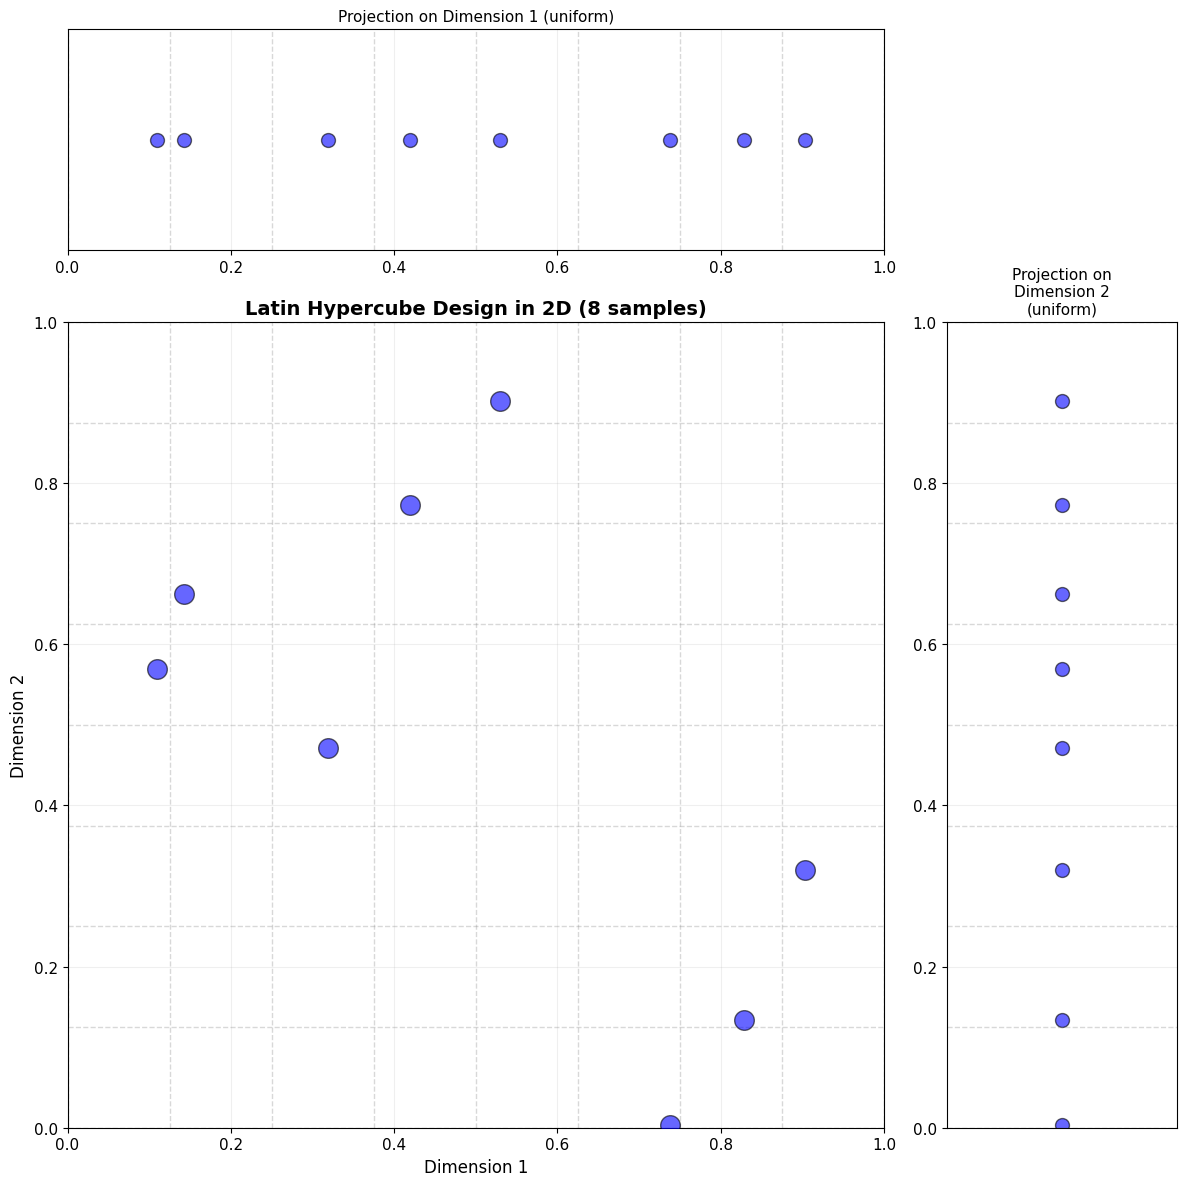


🎯 Key Properties:
1. Each row and column of the grid contains exactly ONE point
2. Projections onto each axis show uniform coverage
3. Points are not aligned (unlike factorial designs)


In [4]:
def visualize_2d_lhd_with_projections(n_samples=8):
    """Visualize 2D LHD with 1D projections showing interval structure."""
    
    # Generate LHS
    sampler = qmc.LatinHypercube(d=2, seed=42)
    lhs_samples = sampler.random(n=n_samples)
    
    # Create figure
    fig = plt.figure(figsize=(12, 12))
    
    # Main 2D plot
    ax_main = plt.subplot2grid((4, 4), (1, 0), colspan=3, rowspan=3)
    ax_main.scatter(lhs_samples[:, 0], lhs_samples[:, 1], s=200, c='blue', alpha=0.6, edgecolors='black', zorder=3)
    
    # Draw grid showing intervals
    for i in range(n_samples + 1):
        ax_main.axvline(x=i/n_samples, color='gray', linestyle='--', alpha=0.3, linewidth=1)
        ax_main.axhline(y=i/n_samples, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    
    ax_main.set_xlim(0, 1)
    ax_main.set_ylim(0, 1)
    ax_main.set_xlabel('Dimension 1', fontsize=12)
    ax_main.set_ylabel('Dimension 2', fontsize=12)
    ax_main.set_title(f'Latin Hypercube Design in 2D ({n_samples} samples)', fontsize=14, fontweight='bold')
    ax_main.grid(True, alpha=0.2)
    
    # Projection on X-axis (top)
    ax_top = plt.subplot2grid((4, 4), (0, 0), colspan=3, sharex=ax_main)
    ax_top.scatter(lhs_samples[:, 0], np.zeros_like(lhs_samples[:, 0]), s=100, c='blue', alpha=0.6, edgecolors='black')
    for i in range(n_samples + 1):
        ax_top.axvline(x=i/n_samples, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax_top.set_ylim(-0.5, 0.5)
    ax_top.set_yticks([])
    ax_top.set_title('Projection on Dimension 1 (uniform)', fontsize=11)
    ax_top.grid(True, alpha=0.2)
    
    # Projection on Y-axis (right)
    ax_right = plt.subplot2grid((4, 4), (1, 3), rowspan=3, sharey=ax_main)
    ax_right.scatter(np.zeros_like(lhs_samples[:, 1]), lhs_samples[:, 1], s=100, c='blue', alpha=0.6, edgecolors='black')
    for i in range(n_samples + 1):
        ax_right.axhline(y=i/n_samples, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax_right.set_xlim(-0.5, 0.5)
    ax_right.set_xticks([])
    ax_right.set_title('Projection on\nDimension 2\n(uniform)', fontsize=11)
    ax_right.grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.show()

visualize_2d_lhd_with_projections(n_samples=8)

print("\n🎯 Key Properties:")
print("1. Each row and column of the grid contains exactly ONE point")
print("2. Projections onto each axis show uniform coverage")
print("3. Points are not aligned (unlike factorial designs)")

## 6. Using SpotOptim for Latin Hypercube Design

Now let's see how **SpotOptim** generates Latin Hypercube Designs for initial sampling.

### How SpotOptim Uses LHD

SpotOptim uses LHD in the `_generate_initial_design()` method, which is called by `_set_initial_design()` when no initial design is provided. Let's explore this:

In [5]:
# Define a simple test function (2D sphere)
def sphere_function(X):
    """Simple quadratic function: f(x,y) = x^2 + y^2"""
    X = np.atleast_2d(X)
    return np.sum(X**2, axis=1)

# Create SpotOptim instance
opt = SpotOptim(
    fun=sphere_function,
    bounds=[(-5, 5), (-5, 5)],  # Search space: [-5, 5] × [-5, 5]
    n_initial=20,                # Number of initial design points
    seed=42                      # For reproducibility
)

# Generate initial design (internally uses LHD)
X0 = opt._set_initial_design()

print(f"Generated {X0.shape[0]} initial design points using LHD")
print(f"Dimensions: {X0.shape[1]}")
print(f"\nFirst 5 points:")
print(X0[:5])

Generated 20 initial design points using LHD
Dimensions: 2

First 5 points:
[[ 1.61302198 -4.71943922]
 [-3.92929896 -4.34868401]
 [-2.54708867  3.51218882]
 [ 2.11943015  4.10696785]
 [-0.06405682  0.27480703]]


### Visualizing SpotOptim's Initial Design

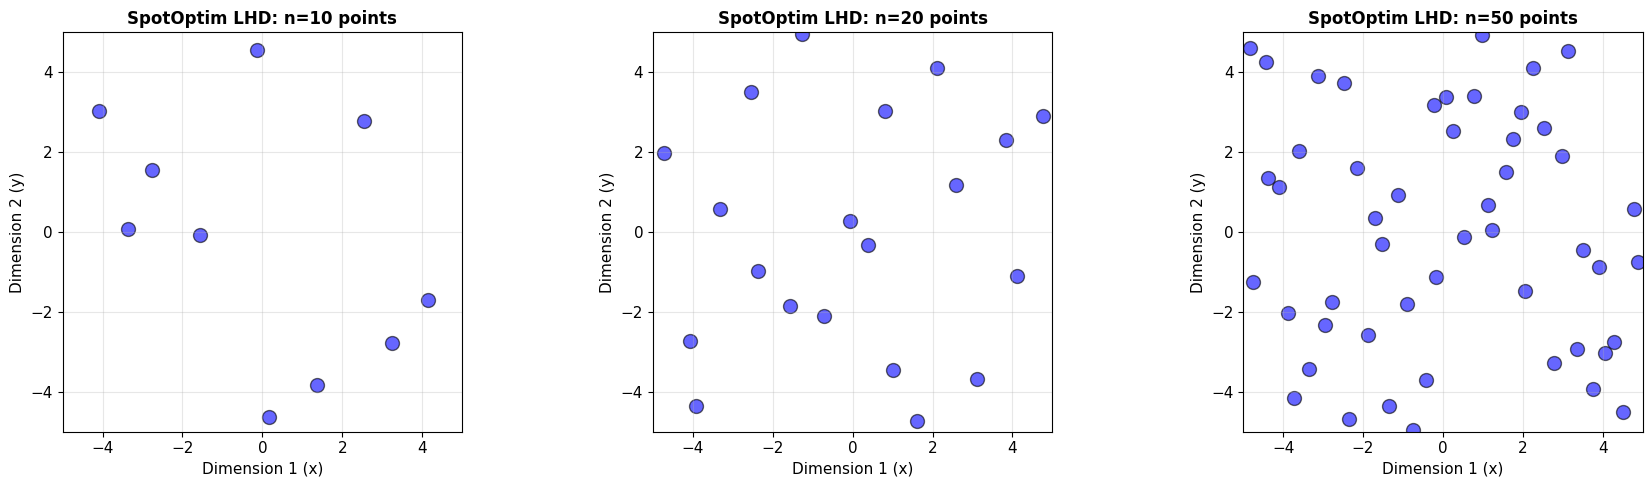


💡 Observation:
As we increase the number of samples, the space-filling property improves.
More points → Better initial coverage → Better surrogate model


In [6]:
# Generate designs with different sample sizes
sample_sizes = [10, 20, 50]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, n in enumerate(sample_sizes):
    opt = SpotOptim(
        fun=sphere_function,
        bounds=[(-5, 5), (-5, 5)],
        n_initial=n,
        seed=42,
        max_iter=50
    )
    X0 = opt._set_initial_design()
    
    axes[idx].scatter(X0[:, 0], X0[:, 1], s=100, c='blue', alpha=0.6, edgecolors='black')
    axes[idx].set_xlim(-5, 5)
    axes[idx].set_ylim(-5, 5)
    axes[idx].set_xlabel('Dimension 1 (x)', fontsize=11)
    axes[idx].set_ylabel('Dimension 2 (y)', fontsize=11)
    axes[idx].set_title(f'SpotOptim LHD: n={n} points', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_aspect('equal')

plt.tight_layout()
plt.show()

print("\n💡 Observation:")
print("As we increase the number of samples, the space-filling property improves.")
print("More points → Better initial coverage → Better surrogate model")

## 7. Comparing Design Quality Metrics

How do we measure the quality of a sampling plan? Several metrics exist:

### 7.1 Minimum Distance

The **minimum pairwise distance** between points. Higher is better (points are well-separated).

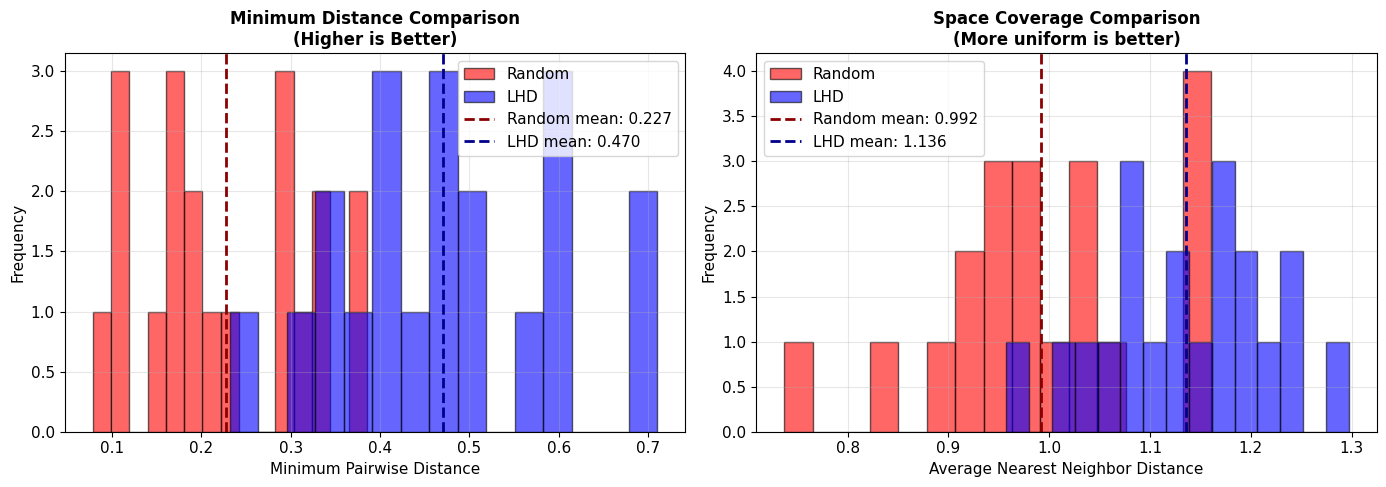


📊 Statistical Comparison (20 trials, 30 samples each):

Minimum Distance:
  Random: 0.2271 ± 0.0937
  LHD:    0.4702 ± 0.1243
  Improvement: 107.0%

Average Coverage:
  Random: 0.9920 ± 0.1056
  LHD:    1.1359 ± 0.0838

✅ LHD provides more consistent, better space-filling properties!


In [7]:
from scipy.spatial.distance import pdist

def compute_min_distance(X):
    """Compute minimum pairwise distance."""
    distances = pdist(X, metric='euclidean')
    return np.min(distances)

def compute_coverage_metric(X):
    """Compute space coverage metric (average distance to nearest neighbor)."""
    from scipy.spatial import distance_matrix
    dist_matrix = distance_matrix(X, X)
    # Set diagonal to infinity to exclude self-distance
    np.fill_diagonal(dist_matrix, np.inf)
    nearest_neighbor_dists = np.min(dist_matrix, axis=1)
    return np.mean(nearest_neighbor_dists)

# Compare Random vs LHD
n_samples = 30
n_trials = 20

random_min_dists = []
lhd_min_dists = []
random_coverage = []
lhd_coverage = []

for trial in range(n_trials):
    # Random sampling
    random_samples = np.random.uniform(-5, 5, size=(n_samples, 2))
    random_min_dists.append(compute_min_distance(random_samples))
    random_coverage.append(compute_coverage_metric(random_samples))
    
    # LHD via SpotOptim
    opt = SpotOptim(
        fun=sphere_function,
        bounds=[(-5, 5), (-5, 5)],
        n_initial=n_samples,
        seed=trial,
        max_iter=50
    )
    lhd_samples = opt._set_initial_design()
    lhd_min_dists.append(compute_min_distance(lhd_samples))
    lhd_coverage.append(compute_coverage_metric(lhd_samples))

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Minimum distance comparison
ax1.hist(random_min_dists, bins=15, alpha=0.6, color='red', label='Random', edgecolor='black')
ax1.hist(lhd_min_dists, bins=15, alpha=0.6, color='blue', label='LHD', edgecolor='black')
ax1.axvline(np.mean(random_min_dists), color='darkred', linestyle='--', linewidth=2, label=f'Random mean: {np.mean(random_min_dists):.3f}')
ax1.axvline(np.mean(lhd_min_dists), color='darkblue', linestyle='--', linewidth=2, label=f'LHD mean: {np.mean(lhd_min_dists):.3f}')
ax1.set_xlabel('Minimum Pairwise Distance', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Minimum Distance Comparison\n(Higher is Better)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Coverage comparison
ax2.hist(random_coverage, bins=15, alpha=0.6, color='red', label='Random', edgecolor='black')
ax2.hist(lhd_coverage, bins=15, alpha=0.6, color='blue', label='LHD', edgecolor='black')
ax2.axvline(np.mean(random_coverage), color='darkred', linestyle='--', linewidth=2, label=f'Random mean: {np.mean(random_coverage):.3f}')
ax2.axvline(np.mean(lhd_coverage), color='darkblue', linestyle='--', linewidth=2, label=f'LHD mean: {np.mean(lhd_coverage):.3f}')
ax2.set_xlabel('Average Nearest Neighbor Distance', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Space Coverage Comparison\n(More uniform is better)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Statistical Comparison ({n_trials} trials, {n_samples} samples each):")
print(f"\nMinimum Distance:")
print(f"  Random: {np.mean(random_min_dists):.4f} ± {np.std(random_min_dists):.4f}")
print(f"  LHD:    {np.mean(lhd_min_dists):.4f} ± {np.std(lhd_min_dists):.4f}")
print(f"  Improvement: {(np.mean(lhd_min_dists) / np.mean(random_min_dists) - 1) * 100:.1f}%")
print(f"\nAverage Coverage:")
print(f"  Random: {np.mean(random_coverage):.4f} ± {np.std(random_coverage):.4f}")
print(f"  LHD:    {np.mean(lhd_coverage):.4f} ± {np.std(lhd_coverage):.4f}")
print(f"\n✅ LHD provides more consistent, better space-filling properties!")

## 8. Latin Hypercube Design in Higher Dimensions

One of the key advantages of LHD is that it scales well to higher dimensions. Let's explore this:

In [8]:
def sphere_nd(X):
    """N-dimensional sphere function."""
    X = np.atleast_2d(X)
    return np.sum(X**2, axis=1)

# Test different dimensions
dimensions = [2, 5, 10, 20]
n_samples = 50

print("\n🔍 Generating LHD in Different Dimensions:")
print("=" * 60)

designs = {}
for d in dimensions:
    bounds = [(-5, 5)] * d
    opt = SpotOptim(
        fun=sphere_nd,
        bounds=bounds,
        n_initial=n_samples,
        seed=42,
        max_iter=50
    )
    X0 = opt._set_initial_design()
    designs[d] = X0
    
    # Compute quality metrics
    min_dist = compute_min_distance(X0)
    coverage = compute_coverage_metric(X0)
    
    print(f"\nDimension: {d:2d}")
    print(f"  Shape: {X0.shape}")
    print(f"  Min distance: {min_dist:.4f}")
    print(f"  Avg coverage: {coverage:.4f}")


🔍 Generating LHD in Different Dimensions:

Dimension:  2
  Shape: (50, 2)
  Min distance: 0.3358
  Avg coverage: 0.8018

Dimension:  5
  Shape: (50, 5)
  Min distance: 2.4419
  Avg coverage: 3.6006

Dimension: 10
  Shape: (50, 10)
  Min distance: 6.0622
  Avg coverage: 7.5712

Dimension: 20
  Shape: (50, 20)
  Min distance: 9.7516
  Avg coverage: 12.7602


### Visualizing Projections in High Dimensions

Since we can't visualize 20D space directly, let's look at 2D projections:

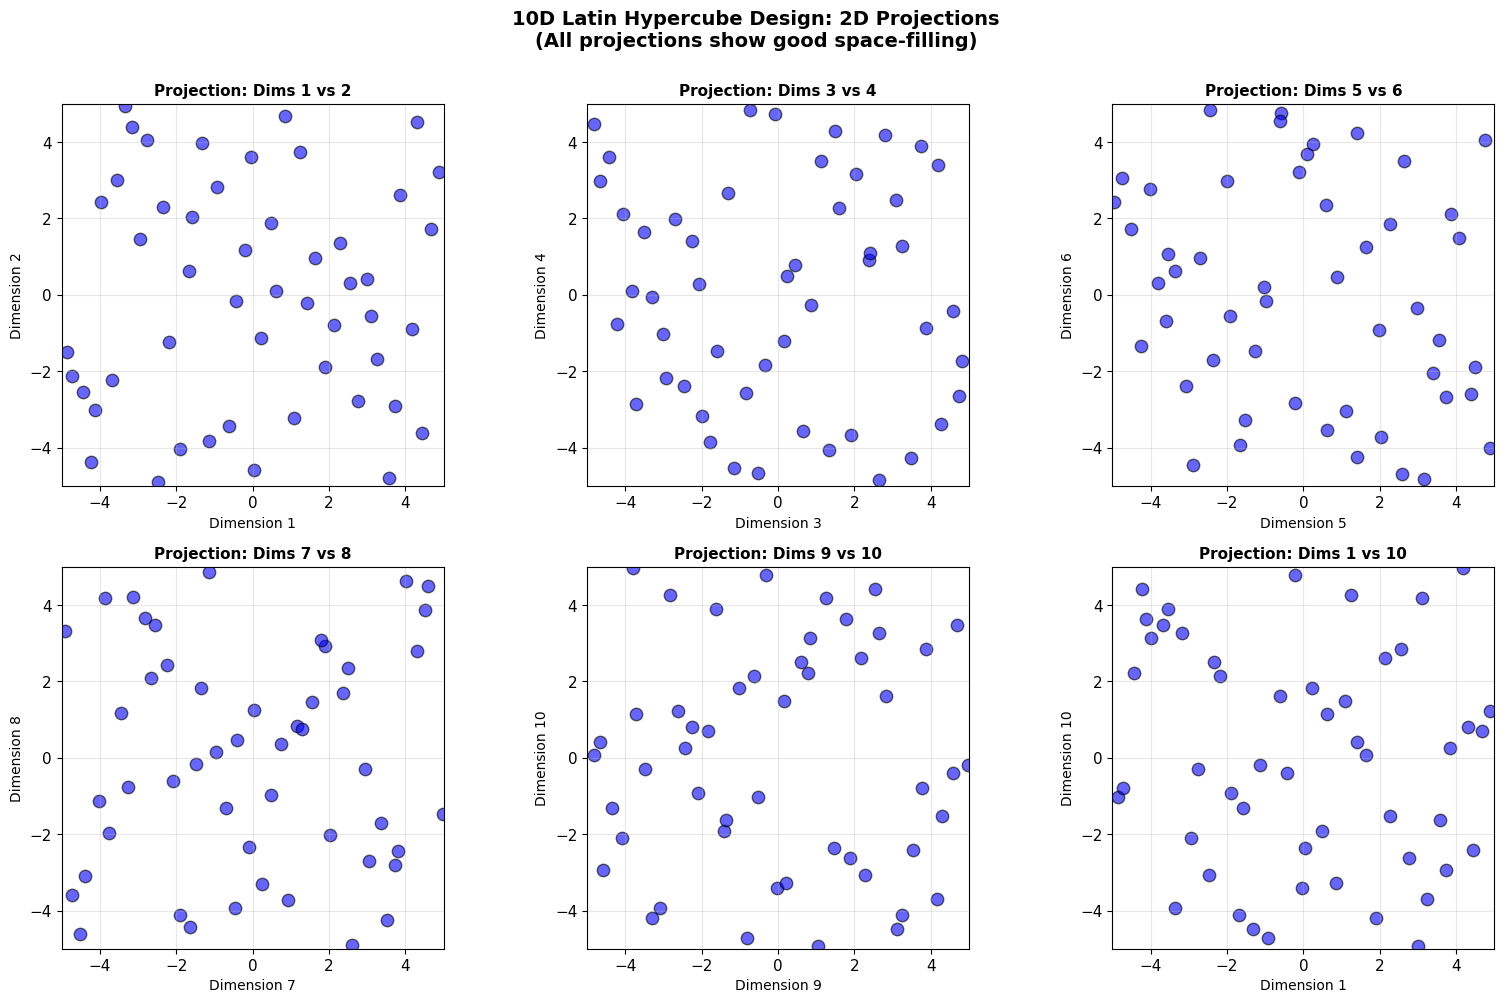


🎯 Key Insight:
LHD maintains space-filling properties in all 2D projections.
This is crucial for surrogate modeling in high dimensions!


In [9]:
# Use 10D design
X_10d = designs[10]

# Create 2x3 subplot showing different 2D projections
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

projection_pairs = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9), (0, 9)]

for idx, (dim1, dim2) in enumerate(projection_pairs):
    axes[idx].scatter(X_10d[:, dim1], X_10d[:, dim2], s=80, c='blue', alpha=0.6, edgecolors='black')
    axes[idx].set_xlim(-5, 5)
    axes[idx].set_ylim(-5, 5)
    axes[idx].set_xlabel(f'Dimension {dim1+1}', fontsize=10)
    axes[idx].set_ylabel(f'Dimension {dim2+1}', fontsize=10)
    axes[idx].set_title(f'Projection: Dims {dim1+1} vs {dim2+1}', fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_aspect('equal')

plt.suptitle('10D Latin Hypercube Design: 2D Projections\n(All projections show good space-filling)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n🎯 Key Insight:")
print("LHD maintains space-filling properties in all 2D projections.")
print("This is crucial for surrogate modeling in high dimensions!")

## 9. Advanced: SpotOptim's Initial Design Features

SpotOptim provides additional flexibility for initial designs:

### 9.1 Custom Starting Point (x0)

You can specify a starting point to include in the initial design:

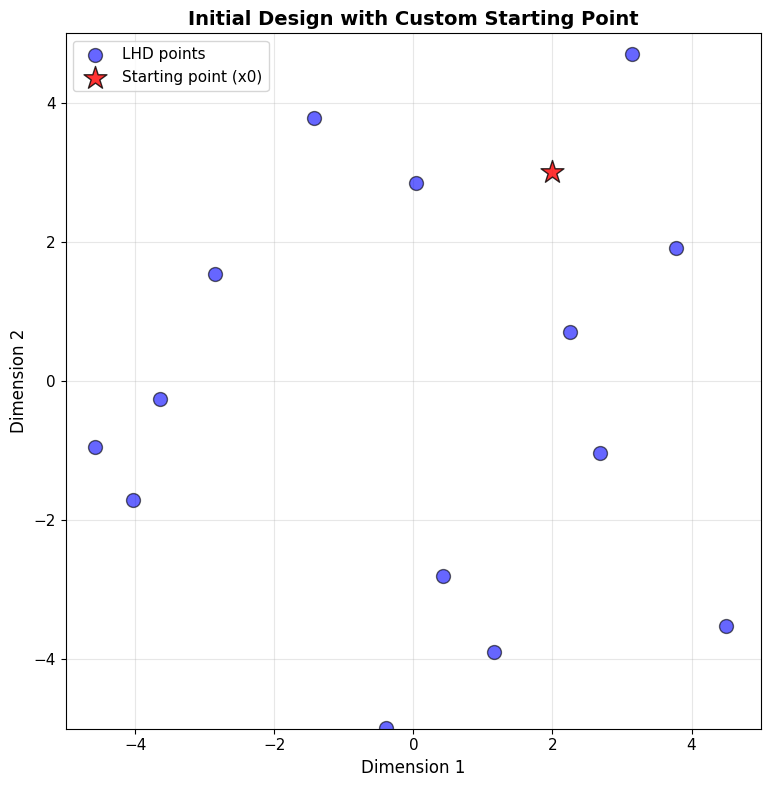


✅ First point is x0: [2. 3.]
   (specified as [2. 3.])

💡 Use Case: Include domain knowledge or previous best solutions


In [10]:
# Create optimizer with starting point
opt_with_x0 = SpotOptim(
    fun=sphere_function,
    bounds=[(-5, 5), (-5, 5)],
    n_initial=15,
    x0=[2.0, 3.0],  # Include this point in initial design
    seed=42
)

X0_with_x0 = opt_with_x0._set_initial_design()

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all initial points
ax.scatter(X0_with_x0[1:, 0], X0_with_x0[1:, 1], s=100, c='blue', alpha=0.6, 
           edgecolors='black', label='LHD points', zorder=2)

# Highlight starting point (first point)
ax.scatter(X0_with_x0[0, 0], X0_with_x0[0, 1], s=300, c='red', alpha=0.8, 
           edgecolors='black', marker='*', label='Starting point (x0)', zorder=3)

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_xlabel('Dimension 1', fontsize=12)
ax.set_ylabel('Dimension 2', fontsize=12)
ax.set_title('Initial Design with Custom Starting Point', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"\n✅ First point is x0: {X0_with_x0[0]}")
print(f"   (specified as {opt_with_x0.x0})")
print(f"\n💡 Use Case: Include domain knowledge or previous best solutions")

### 9.2 Custom Initial Design

You can also provide a completely custom initial design:

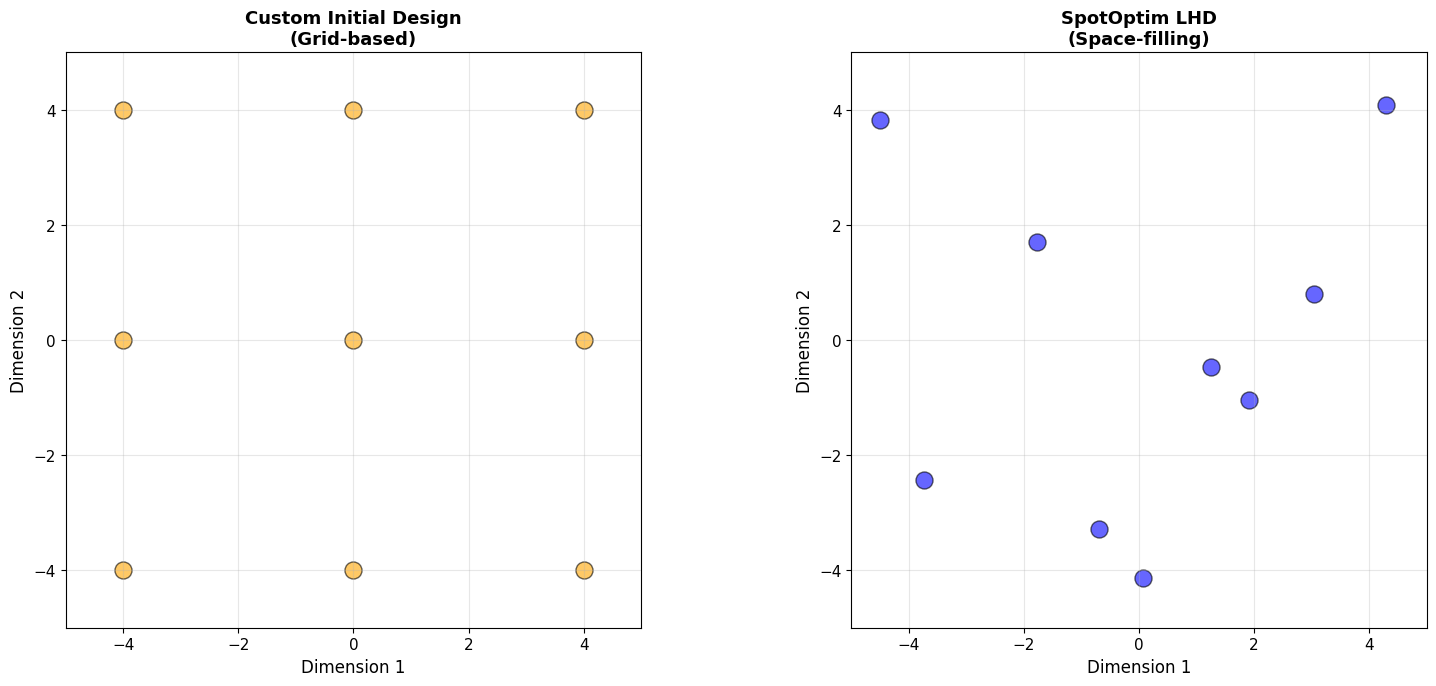


💡 When to use custom designs:
  - Incorporating expert knowledge
  - Testing specific regions of interest
  - Combining with previous experiments

⚠️  However, LHD usually provides better general-purpose coverage!


In [11]:
# Create custom initial design (e.g., points around the boundary)
custom_X0 = np.array([
    [-4, -4], [-4, 0], [-4, 4],
    [0, -4],  [0, 0],  [0, 4],
    [4, -4],  [4, 0],  [4, 4]
])

opt_custom = SpotOptim(
    fun=sphere_function,
    bounds=[(-5, 5), (-5, 5)],
    seed=42
)

X0_custom = opt_custom._set_initial_design(X0=custom_X0)

# Compare LHD vs Custom
opt_lhd = SpotOptim(
    fun=sphere_function,
    bounds=[(-5, 5), (-5, 5)],
    n_initial=9,
    seed=42
)
X0_lhd = opt_lhd._set_initial_design()

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Custom design
ax1.scatter(X0_custom[:, 0], X0_custom[:, 1], s=150, c='orange', alpha=0.6, edgecolors='black')
ax1.set_xlim(-5, 5)
ax1.set_ylim(-5, 5)
ax1.set_xlabel('Dimension 1', fontsize=12)
ax1.set_ylabel('Dimension 2', fontsize=12)
ax1.set_title('Custom Initial Design\n(Grid-based)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')

# LHD design
ax2.scatter(X0_lhd[:, 0], X0_lhd[:, 1], s=150, c='blue', alpha=0.6, edgecolors='black')
ax2.set_xlim(-5, 5)
ax2.set_ylim(-5, 5)
ax2.set_xlabel('Dimension 1', fontsize=12)
ax2.set_ylabel('Dimension 2', fontsize=12)
ax2.set_title('SpotOptim LHD\n(Space-filling)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

print("\n💡 When to use custom designs:")
print("  - Incorporating expert knowledge")
print("  - Testing specific regions of interest")
print("  - Combining with previous experiments")
print("\n⚠️  However, LHD usually provides better general-purpose coverage!")

## 10. Practical Example: Initial Design for Real Optimization

Let's see how the initial design affects a real optimization problem.

### Test Function: Branin Function

The Branin function is a common benchmark with 3 global minima.

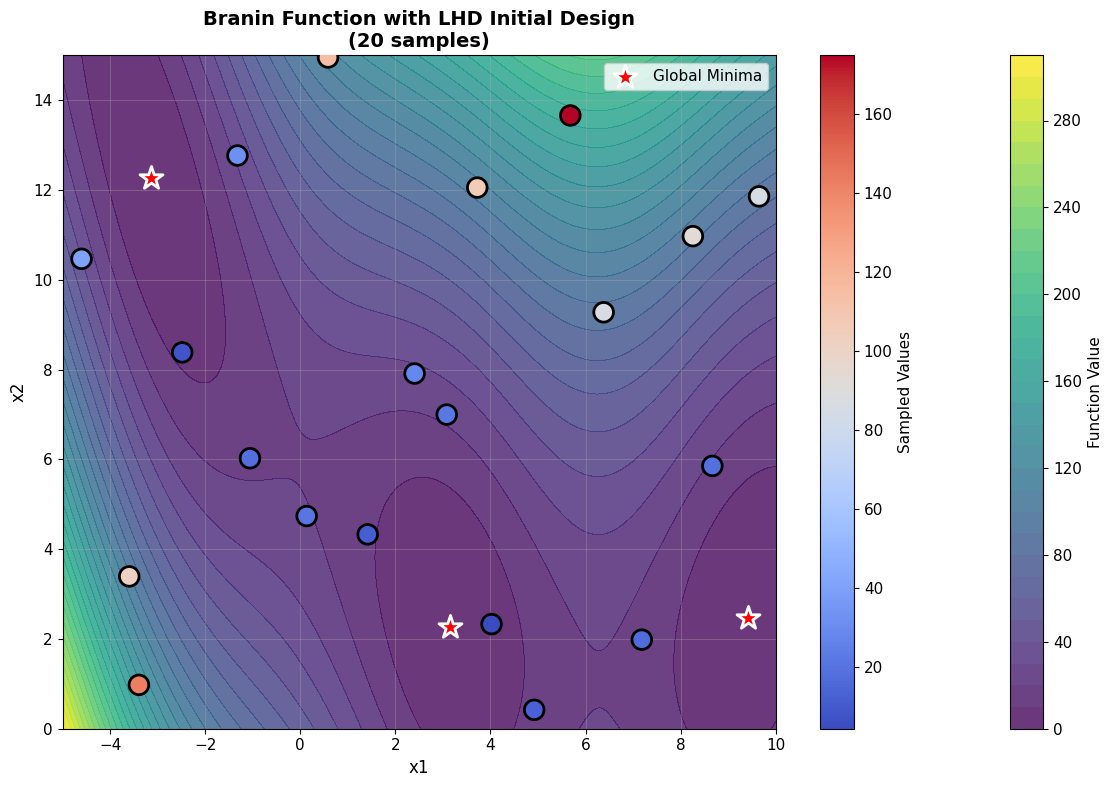


📊 Initial Design Statistics:
  Number of samples: 20
  Best value found: 4.296503
  Best location: [4.02197648 2.33015916]
  Global optimum: ≈ 0.397887

💡 The LHD samples provide good coverage of the entire space,
   including regions near all three global minima!


In [12]:
def branin(X):
    """
    Branin function (2D optimization benchmark).
    
    Global minima at:
    - f(-π, 12.275) ≈ 0.397887
    - f(π, 2.275) ≈ 0.397887
    - f(9.42478, 2.475) ≈ 0.397887
    """
    X = np.atleast_2d(X)
    x1 = X[:, 0]
    x2 = X[:, 1]
    
    a = 1
    b = 5.1 / (4 * np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    
    y = a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1-t)*np.cos(x1) + s
    return y

# Visualize the Branin function
x1_range = np.linspace(-5, 10, 200)
x2_range = np.linspace(0, 15, 200)
X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)
X_grid = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])
Y_grid = branin(X_grid).reshape(X1_grid.shape)

# Create SpotOptim with LHD
opt_branin = SpotOptim(
    fun=branin,
    bounds=[(-5, 10), (0, 15)],
    n_initial=20,
    seed=42
)

X0_branin = opt_branin._set_initial_design()
Y0_branin = branin(X0_branin)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Contour plot of Branin function
contour = ax.contourf(X1_grid, X2_grid, Y_grid, levels=30, cmap='viridis', alpha=0.8)
plt.colorbar(contour, ax=ax, label='Function Value')

# Overlay initial design points
scatter = ax.scatter(X0_branin[:, 0], X0_branin[:, 1], c=Y0_branin, s=200, 
                     cmap='coolwarm', edgecolors='black', linewidth=2, 
                     vmin=Y0_branin.min(), vmax=Y0_branin.max(), zorder=3)
plt.colorbar(scatter, ax=ax, label='Sampled Values')

# Mark the three global minima
global_minima = np.array([[-np.pi, 12.275], [np.pi, 2.275], [9.42478, 2.475]])
ax.scatter(global_minima[:, 0], global_minima[:, 1], s=300, c='red', 
           marker='*', edgecolors='white', linewidth=2, 
           label='Global Minima', zorder=4)

ax.set_xlabel('x1', fontsize=12)
ax.set_ylabel('x2', fontsize=12)
ax.set_title('Branin Function with LHD Initial Design\n(20 samples)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Initial Design Statistics:")
print(f"  Number of samples: {len(Y0_branin)}")
print(f"  Best value found: {Y0_branin.min():.6f}")
print(f"  Best location: {X0_branin[np.argmin(Y0_branin)]}")
print(f"  Global optimum: ≈ 0.397887")
print(f"\n💡 The LHD samples provide good coverage of the entire space,")
print(f"   including regions near all three global minima!")

## 11. Key Takeaways and Best Practices

### Summary of Latin Hypercube Design

✅ **What is LHD?**
- Stratified sampling method that divides each dimension into equal intervals
- Ensures exactly one sample per interval in each dimension
- Provides excellent space-filling properties

✅ **Why use LHD?**
- Better coverage than random sampling
- More efficient use of expensive function evaluations
- Scales well to high dimensions
- Provides good 1D projection properties

✅ **When to use LHD?**
- Initial sampling for surrogate modeling
- Expensive black-box optimization
- Computer experiments and simulations
- Hyperparameter tuning

### Best Practices

1. **Sample Size**: Use at least `10d` samples for `d` dimensions (rule of thumb)
   - Minimum: `3d` for simple problems
   - Better: `10d - 20d` for complex landscapes

2. **SpotOptim's `n_initial` Parameter**: 
   ```python
   opt = SpotOptim(
       fun=expensive_function,
       bounds=bounds,
       n_initial=10 * n_dimensions,  # Good starting point
       seed=42  # For reproducibility
   )
   ```

3. **When to Customize**:
   - Use `x0` to include known good solutions
   - Use custom `X0` for incorporating expert knowledge
   - Otherwise, trust SpotOptim's default LHD!

4. **Quality Checks**:
   - Visualize projections for 2D/3D problems
   - Check minimum pairwise distance
   - Ensure coverage of the entire design space

## 12. Looking Ahead: Next Tutorial

In **Tutorial 2: Constructing a Surrogate Model**, we'll explore:

- What is a surrogate model and why do we need one?
- Different types of surrogates (Gaussian Processes, Random Forests, etc.)
- How SpotOptim fits surrogate models using `_fit_surrogate()`
- Predicting with uncertainty using `_predict_with_uncertainty()`
- Surrogate model selection and hyperparameters
- Visualization of surrogate predictions

### Preview Question:

*Given the initial design we created with LHD, how do we build a model that can predict function values at unsampled locations?*

That's what we'll cover next! 🚀

## 13. Exercises (Optional)

Try these exercises to deepen your understanding:

### Exercise 1: Compare Design Strategies
Generate and compare 3 different sampling strategies for a 3D problem:
- Random sampling
- Grid-based sampling (factorial design)
- Latin Hypercube Design

Compute and compare their space-filling properties.

### Exercise 2: High-Dimensional LHD
Create a 50-dimensional LHD with 500 samples. Examine:
- 2D projections for different dimension pairs
- Minimum distance statistics
- Coverage metrics

### Exercise 3: Custom Initial Design
For the Branin function:
- Create a custom initial design with your own points
- Compare its coverage to LHD
- Which design finds better initial values?

### Exercise 4: Scaling Study
Study how LHD quality changes with sample size:
- Test n = [10, 20, 50, 100, 200] samples in 5D
- Plot minimum distance vs. sample size
- What's the "sweet spot" for your computational budget?

## References

1. McKay, M. D., Beckman, R. J., & Conover, W. J. (1979). A comparison of three methods for selecting values of input variables in the analysis of output from a computer code. *Technometrics*, 21(2), 239-245.

2. Forrester, A., Sobester, A., & Keane, A. (2008). *Engineering Design via Surrogate Modelling: A Practical Guide*. Wiley.

3. Santner, T. J., Williams, B. J., & Notz, W. I. (2003). *The Design and Analysis of Computer Experiments*. Springer.

4. Jones, D. R. (2001). A taxonomy of global optimization methods based on response surfaces. *Journal of Global Optimization*, 21(4), 345-383.

5. Sequential Parameter Optimization Group. (2024). *Hyperparameter Tuning Cookbook*. [https://sequential-parameter-optimization.github.io/Hyperparameter-Tuning-Cookbook/](https://sequential-parameter-optimization.github.io/Hyperparameter-Tuning-Cookbook/)

---

**Next:** [Tutorial 2 - Constructing a Surrogate Model](02_constructing_surrogate.ipynb)